In [1]:
from colorcloud.UFGsim2024infufg import SemanticSegmentationSimLDM, ProjectionSimVizTransform, UFGSimDataset
from colorcloud.biasutti2019riu import SemanticSegmentationTask, RIUNet
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
import lightning as L
import wandb
import time
from lightning.pytorch.loggers import WandbLogger
from datetime import datetime
import torch
import numpy as np
from tqdm import tqdm
from torchmetrics.classification import Accuracy
from torchmetrics.segmentation import MeanIoU
from torchmetrics.classification import Dice

In [2]:
data = SemanticSegmentationSimLDM()
data.setup('fit')
data.setup('test')
data_path = '../UFGSim/'
train_ds = UFGSimDataset(data_path)
test_ds = UFGSimDataset(data_path, split='test')

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
model = RIUNet(in_channels=4, hidden_channels=(64, 128, 256, 512), n_classes=13).to(device)
loss_func = CrossEntropyLoss(reduction='none')
n_epochs = 5
opt = AdamW(model.parameters(), lr=5e-4, eps=1e-5)
train_steps = len(train_ds) // 8
test_steps = len(test_ds) // 16

accuracy = Accuracy(task="multiclass", num_classes=model.n_classes).to(device)
accuracy_dict = {"train": [], "val": []}

miou = MeanIoU(num_classes=model.n_classes).to(device)
miou_dict = {"train": [], "val": []}

dice = Dice(num_classes=model.n_classes).to(device)
dice_dict = {"train": [], "val": []}

H = {"train_loss": [], "test_loss": []}

In [11]:
print("!!! TRAINING !!!")
start_time = time.time()

for epochs in tqdm(range(n_epochs)):

    model.train()

    total_train_loss = 0
    total_test_loss = 0

    for batch in data.train_dataloader():
        train_item = {key: value.to(device) for key, value in batch.items()}
        img = train_item['frame']
        label = train_item['label']
        mask = train_item['mask']

        label[~mask] = 0

        pred = model(img)
        train_loss = loss_func(pred, label)
        train_loss = train_loss[mask]
        train_loss = train_loss.mean()

        pred_f = torch.permute(pred, (0, 2, 3, 1)) # N,C,H,W -> N,H,W,C
        pred_f = torch.flatten(pred_f, 0, -2)      # N,H,W,C -> N*H*W,C
        mask_f = torch.flatten(mask)               # N,H,W   -> N*H*W
        pred_m = pred_f[mask_f, :]
        label_m = label[mask]
        current_train_acc = accuracy(pred_m, label_m)
        accuracy_dict["train"].append(current_train_acc)

        pred_labels = torch.argmax(pred, dim=1).to(device)
        mask_miou = (label != 0)
        pred_labels[~mask] = 0
        current_train_miou = miou(pred_labels, label)
        miou_dict["train"].append(current_train_miou)
        current_train_dice = dice(pred_labels, label)
        dice_dict["train"].append(current_train_dice)
        
        opt.zero_grad()
        train_loss.backward()
        opt.step()

        total_train_loss += train_loss


    with torch.no_grad():

        model.eval()

        for batch in data.test_dataloader():
            test_item = {key: value.to(device) for key, value in batch.items()}
            img = test_item['frame']
            label = test_item['label']
            mask = test_item['mask']
    
            label[~mask] = 0
    
            pred = model(img)
            test_loss = loss_func(pred, label)
            test_loss = test_loss[mask]
            test_loss = test_loss.mean()

            pred_f = torch.permute(pred, (0, 2, 3, 1)) # N,C,H,W -> N,H,W,C
            pred_f = torch.flatten(pred_f, 0, -2)      # N,H,W,C -> N*H*W,C
            mask_f = torch.flatten(mask)               # N,H,W   -> N*H*W
            pred_m = pred_f[mask_f, :]
            label_m = label[mask]
            current_test_acc = accuracy(pred_m, label_m)
            accuracy_dict["val"].append(current_test_acc)
        
            pred_labels = torch.argmax(pred, dim=1).to(device)
            mask_miou = (label != 0)
            pred_labels[~mask] = 0
            current_test_miou = miou(pred_labels, label)
            miou_dict["val"].append(current_test_miou)
            current_test_dice = dice(pred_labels, label)
            dice_dict["val"].append(current_test_dice)

            total_test_loss += test_loss

    avg_train_loss = total_train_loss / train_steps
    avg_test_loss = total_test_loss / test_steps

    # Store loss history for graphical visualization
    H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
    H["test_loss"].append(avg_test_loss.cpu().detach().numpy())
    
    print("CURRENT EPOCH: {}/{}".format(epochs + 1, n_epochs))
    print("Train loss: {:.10f}, Test loss {:.4f}".format(avg_train_loss, avg_test_loss))

end_time = time.time()
print("Training took {:.2f}s".format(end_time - start_time))
print("Accuracy: {:.4f} on training and {:.4f} on testing".format(current_train_acc, current_test_acc))
print("Mean IOU: {:.4f} on training and {:.4f} on testing".format(current_train_miou, current_test_miou))
print("Dice: {:.4f} on training and {:.4f} on testing".format(current_train_miou, current_test_miou))

!!! TRAINING !!!


 20%|█████████████████                                                                    | 1/5 [00:39<02:36, 39.10s/it]

CURRENT EPOCH: 1/5
Train loss: 0.0335198008, Test loss 0.1441


 40%|██████████████████████████████████                                                   | 2/5 [01:16<01:54, 38.33s/it]

CURRENT EPOCH: 2/5
Train loss: 0.0220987927, Test loss 0.1256


 60%|███████████████████████████████████████████████████                                  | 3/5 [01:54<01:16, 38.05s/it]

CURRENT EPOCH: 3/5
Train loss: 0.0108853960, Test loss 0.1311


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [02:32<00:37, 38.00s/it]

CURRENT EPOCH: 4/5
Train loss: 0.0083855931, Test loss 0.1433


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:10<00:00, 38.09s/it]

CURRENT EPOCH: 5/5
Train loss: 0.0069141965, Test loss 0.1490
Training took 190.44s
Accuracy: 0.9976 on training and 0.9919 on testing
Mean IOU: 0.6979 on training and 0.3731 on testing
Dice: 0.6979 on training and 0.3731 on testing


In [14]:
torch.save(model, "ufgsim_riunet_torch.pt")

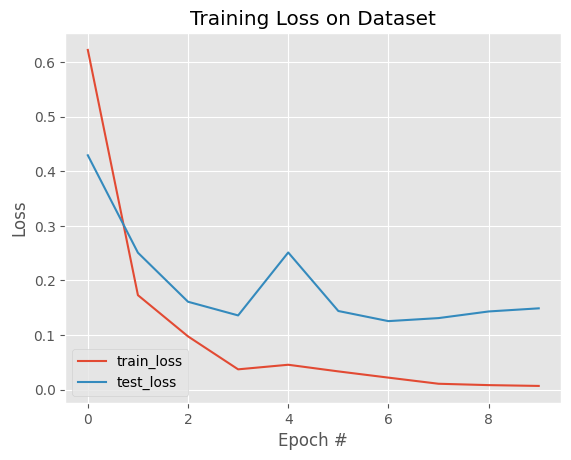

In [12]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

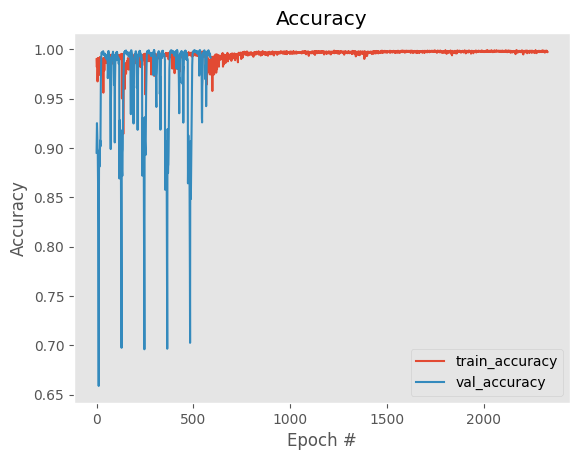

In [13]:
# Accuracy
plt.style.use("ggplot")
plt.figure()

train_accuracy = [x.cpu().numpy() for x in accuracy_dict["train"]]
val_accuracy = [x.cpu().numpy() for x in accuracy_dict["val"]]

plt.plot(train_accuracy, label="train_accuracy")
plt.plot(val_accuracy, label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.grid()
plt.show()

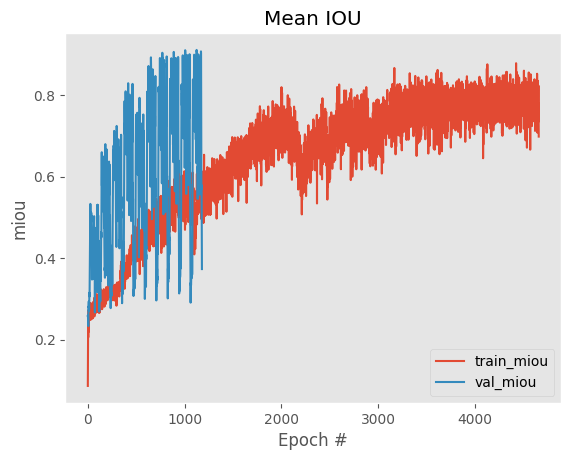

In [14]:
# Mean IoU
train_miou = [x.cpu().numpy() for x in miou_dict["train"]]
val_miou = [x.cpu().numpy() for x in miou_dict["val"]]

plt.plot(train_miou, label="train_miou")
plt.plot(val_miou, label="val_miou")
plt.title("Mean IOU")
plt.xlabel("Epoch #")
plt.ylabel("miou")
plt.legend(loc="lower right")
plt.grid()
plt.show()

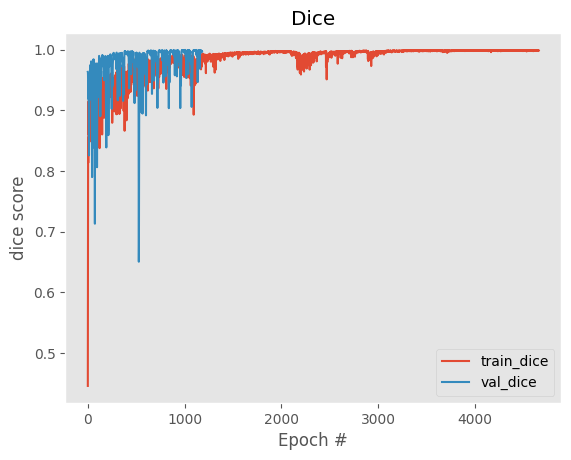

In [15]:
# Dice
train_dice = [x.cpu().numpy() for x in dice_dict["train"]]
val_dice = [x.cpu().numpy() for x in dice_dict["val"]]

plt.plot(train_dice, label="train_dice")
plt.plot(val_dice, label="val_dice")
plt.title("Dice")
plt.xlabel("Epoch #")
plt.ylabel("dice score")
plt.legend(loc="lower right")
plt.grid()
plt.show()